In [34]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

np.random.seed(0)

In [35]:
filenames = [os.path.join(folder, filename) for folder in os.listdir('models/scannet_1/models/weights_17/predictions')
             for filename in os.listdir(os.path.join('models/scannet_1/models/weights_17/predictions', folder))
             if os.path.splitext(filename)[1] == '.npy']

np.random.shuffle(filenames)
filenames[:5]

['scene0024_01/242.npy',
 'scene0000_00/571.npy',
 'scene0000_01/403.npy',
 'scene0024_01/337.npy',
 'scene0000_00/283.npy']

In [96]:
model_dict = dict()
model_dict['Default'] = 'models/scannet_1/models/weights_17'
model_dict['Resnet-50'] = 'models/scannet_2/models/weights_13'
model_dict['Pred. Mask'] = 'models/scannet_3/models/weights_14'
model_dict['Single Scale'] = 'models/scannet_4/models/weights_19'
model_dict['No SSIM'] = 'models/scannet_5/models/weights_6'

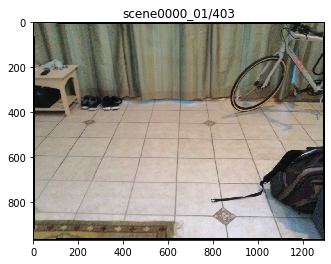

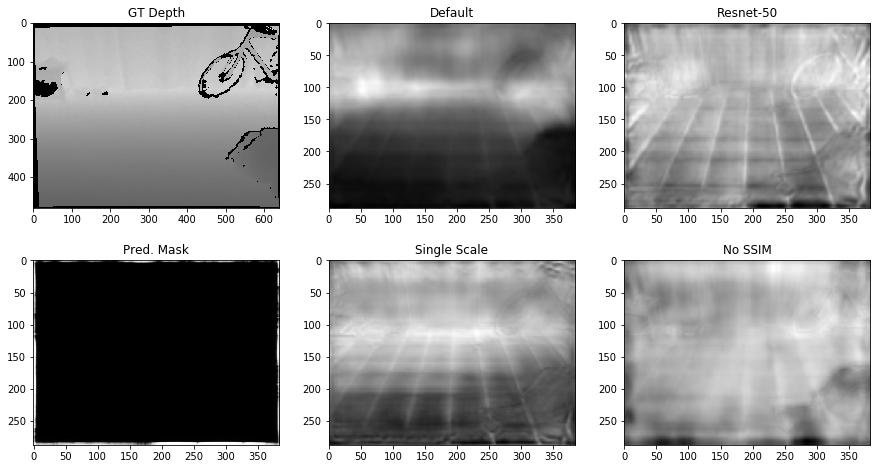

In [103]:
tgt_filepath = filenames[2]

rgb = Image.open(os.path.join('data/imgs', tgt_filepath.replace('.npy', '.png')))
gt_depth = np.load(os.path.join('data/depths', tgt_filepath))
gt_depth = (gt_depth - gt_depth.min()) / (gt_depth.max() - gt_depth.min())


plt.imshow(rgb)
plt.title(os.path.splitext(tgt_filepath)[0])
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()

ax[0].imshow(gt_depth, 'gray')
ax[0].set_title('GT Depth')

for idx, (model_name, model_path) in enumerate(model_dict.items()):
    pred_disp = np.load(os.path.join(model_path, 'predictions', tgt_filepath))
    pred_depth = 1 / pred_disp
    pred_depth = (pred_depth - pred_depth.min()) / (pred_depth.max() - pred_depth.min())
    ax[idx+1].imshow(pred_depth, 'gray')
    ax[idx+1].set_title(model_name)
    
# plt.tight_layout()
plt.show()